# Pre-masking pipeline

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
import pydicom
from PIL import Image
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Loading in images and setting up device

In [2]:
# ─── 1) FIX ALL SOURCES OF RANDOMNESS ────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def load_dicom_as_pil(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img = (img * 255).round().astype(np.uint8)
    return Image.fromarray(img)

In [4]:
# ─── 2) DEVICE ───────────────────────────────────────────────────────
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [5]:
# CHANGE FOR NEW DATA WHEN WE HAVE THE NEW MODEL --> ASK JIWOO FOR IT
# ─── 3) HARD-CODE TRAINING MEAN & STD ────────────────────────────────
TRAIN_MEAN = 0.5037
TRAIN_STD  = 0.2510

In [6]:
# ─── 4) TRANSFORM FOR TEST IMAGES ────────────────────────────────────
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([TRAIN_MEAN], [TRAIN_STD])
])

In [7]:
# ─── 5) DATASET & DATALOADER ────────────────────────────────────────
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx, transform):
        self.items     = items
        self.labels    = labels_dict
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds         = pydicom.dcmread(path)
        arr        = ds.pixel_array.astype(np.float32)

        # normalize to [0,1] using numpy.ptp
        arr_min = arr.min()
        arr_ptp = np.ptp(arr)
        arr_norm = (arr - arr_min) / (arr_ptp + 1e-6)

        # convert back to 8-bit and apply transforms
        img = Image.fromarray((arr_norm * 255).astype(np.uint8))
        img = self.transform(img)

        lbl = self.labels[(pid, path)]
        return img, self.label2idx[lbl]

In [8]:
# ─── 6) LOAD TEST ITEMS & LABELS ────────────────────────────────────
local_path_stem = "/Users/conniechen/Downloads/advanced_ds/final_project/physionet.org/files/mimic-cxr/2.1.0/"
df_preds        = pd.read_csv("reproduceable_model_pred.csv")

# build label mapping
all_labels   = df_preds['true_label']
unique_labels = sorted(all_labels.unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}

# collect (pid, full_path) and labels_dict
test_items  = []
labels_dict = {}
for _, row in df_preds.iterrows():
    pid        = row['subject_id']
    other_path = row['dicom_path'].split('2.1.0')[1]
    full_path  = os.path.join(local_path_stem, other_path.lstrip('/'))
    if not os.path.exists(full_path):
        continue
    test_items.append((pid, full_path))
    labels_dict[(pid, full_path)] = row['true_label']

# create DataLoader
test_loader = DataLoader(
    DicomDataset(test_items, labels_dict, label2idx, test_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [9]:
# ─── 7) BUILD MODEL & LOAD WEIGHTS ─────────────────────────────────
num_classes = len(unique_labels)

model = densenet121(pretrained=True)
# swap first conv to accept 1 channel
old = model.features.conv0
new = nn.Conv2d(
    1, old.out_channels,
    old.kernel_size, old.stride, old.padding,
    bias=(old.bias is not None)
)
with torch.no_grad():
    new.weight[:] = old.weight.mean(dim=1, keepdim=True)
    if old.bias is not None:
        new.bias[:] = old.bias
model.features.conv0 = new

# replace classifier
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# load your trained weights
model.load_state_dict(torch.load("reproduceable_densenet.pt", map_location=device))
model.eval()

/Users/conniechen/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conniechen/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Checking for variability

In [10]:
from_test = pd.read_csv('reproduceable_model_pred.csv')
from_loading = pd.read_csv('predictions.csv')
jiwoo_stem = '/Users/jiwoo_noh/Downloads'

# New: list to hold updated rows
updated_rows = []

# Track count of threshold exceedances
threshold = 0.001
count_exceeds = 0
total_checked = 0

for _, row in from_loading.iterrows():
    dicom_id = row['full_path'].split('final_project')[1]
    search_path = jiwoo_stem + dicom_id
    prob_list = [row['prob_class_0'], row['prob_class_1'], row['prob_class_2'], row['prob_class_3']]

    mask = from_test['dicom_path'] == search_path
    if not mask.any():
        print(f"{search_path!r} not found in from_test")
        continue
    
    total_checked += 1  # ✅ Count how many valid comparisons we made

    # grab the packed‐string out of your test set
    raw = from_test.loc[mask, 'probabilities'].iloc[0]

    # if it’s a string, turn it into a Python list
    if isinstance(raw, str):
        raw = ast.literal_eval(raw)

    # make numpy arrays
    a = np.array(raw, dtype=float)
    b = np.array(prob_list, dtype=float)

    diffs = a - b
    max_abs = np.max(np.abs(diffs))

    # New: check if threshold is exceeded
    exceeds = int(max_abs > threshold)
    if exceeds:
        count_exceeds += 1

    # Add flag to row and save it
    updated_row = row.copy()
    updated_row["exceeds_threshold"] = exceeds
    updated_rows.append(updated_row)

# Save updated DataFrame
updated_df = pd.DataFrame(updated_rows)
updated_df.to_csv("predictions_with_threshold_check.csv", index=False)
print(f"Total predictions compared: {total_checked}")
print(f"Saved predictions_with_threshold_check.csv with {count_exceeds} threshold violations (max_abs > {threshold})")


Total predictions compared: 132
Saved predictions_with_threshold_check.csv with 0 threshold violations (max_abs > 0.001)


# Masking

## Apply mask

In [11]:
def apply_mask(x, mask, mode='keep'):
    noise = torch.randn_like(x)
    if mode == 'keep':
        return x * mask + noise * (1 - mask)
    elif mode == 'remove':
        return x * (1 - mask) + noise * mask

## Explanation loss

In [12]:
def explanation_loss(model, x, mask, alpha=0.5, return_components=False):
    with torch.no_grad():
        y_orig = model(x)

    x_keep = apply_mask(x, mask, mode='keep')
    x_remove = apply_mask(x, mask, mode='remove')

    y_keep = model(x_keep)
    y_remove = model(x_remove)

    loss_suf = F.mse_loss(y_keep, y_orig)
    loss_nec = F.mse_loss(y_remove, torch.mean(y_orig, dim=0, keepdim=True))

    l1_penalty = mask.abs().mean()
    tv_penalty = (
        torch.abs(mask[:, :, :, :-1] - mask[:, :, :, 1:]).mean() +
        torch.abs(mask[:, :, :-1, :] - mask[:, :, 1:, :]).mean()
    )

    loss = alpha * loss_suf + (1 - alpha) * loss_nec + 0.01 * l1_penalty + 0.01 * tv_penalty

    if return_components:
        pred_orig = y_orig.argmax(dim=1).item()
        pred_keep = y_keep.argmax(dim=1).item()
        pred_remove = y_remove.argmax(dim=1).item()

        return loss, {
            'loss': loss.item(),
            'sufficiency': loss_suf.item(),
            'necessity': loss_nec.item(),
            'l1': l1_penalty.item(),
            'tv': tv_penalty.item(),
            'changed_with_keep': pred_keep != pred_orig,
            'changed_with_remove': pred_remove != pred_orig
        }
    return loss

## Evaluate Explanation Loss

In [13]:
def evaluate_explanation_loss(model, x, alpha=0.5, mask_init="random", return_components=True):
    device = x.device
    if isinstance(mask_init, str):
        if mask_init == "random":
            mask = torch.rand_like(x).to(device)
        elif mask_init == "ones":
            mask = torch.ones_like(x).to(device)
        elif mask_init == "zeros":
            mask = torch.zeros_like(x).to(device)
        else:
            raise ValueError(f"Unknown mask_init: {mask_init}")
    else:
        mask = mask_init.to(device)
    return explanation_loss(model, x, mask, alpha, return_components), mask

## Optimize Loss

In [14]:
def optimize_mask(model, x, alpha=1.0, lr=1e-2, log_every=50, tol=1e-6, max_no_improve=10):
    """
    Optimize a mask to minimize explanation_loss over a single input.
    
    Args:
        model: Trained model.
        x: Input image tensor (1, 1, H, W).
        alpha: Weight for sufficiency (1.0) vs necessity (0.0).
        lr: Learning rate.
        log_every: Print loss every N steps.
        tol: Tolerance for early stopping.
        max_no_improve: Number of steps without improvement to stop early.
    
    Returns:
        final_mask: Optimized mask tensor.
        mask_history: List of masks over time (for visualization).
        changed_class: Bool flag if prediction was changed by final mask.
    """
    mask = torch.nn.Parameter(torch.rand_like(x), requires_grad=True)
    optimizer = torch.optim.Adam([mask], lr=lr)

    mask_history = []
    prev_loss = float('inf')
    no_improve_count = 0
    step = 0
    changed_class = False

    try:
        while True:
            optimizer.zero_grad()
            loss, components = explanation_loss(model, x, mask, alpha=alpha, return_components=True)
            loss.backward()
            optimizer.step()
            mask.data.clamp_(0, 1)

            if (step + 1) % log_every == 0 or step == 0:
                print(f"Step {step+1:4d}: "
                      f"Loss={components['loss']:.6f} | "
                      f"Suff={components['sufficiency']:.6f} | "
                      f"Nec={components['necessity']:.6f} | "
                      f"L1={components['l1']:.6f} | "
                      f"TV={components['tv']:.6f} | "
                      f"Changed (keep): {components['changed_with_keep']} | "
                      f"Changed (remove): {components['changed_with_remove']}")
                mask_history.append(mask.detach().cpu().clone())

                if alpha == 1.0 and components['changed_with_keep']:
                    changed_class = True
                elif alpha == 0.0 and components['changed_with_remove']:
                    changed_class = True

            # Early stopping
            loss_delta = abs(prev_loss - components['loss'])
            if loss_delta < tol:
                no_improve_count += 1
                if no_improve_count >= max_no_improve:
                    print(f"Converged at step {step+1} (loss change < {tol} for {max_no_improve} steps)")
                    break
            else:
                no_improve_count = 0

            prev_loss = components['loss']
            step += 1

    except KeyboardInterrupt:
        print(f"\n⏹️ Optimization manually interrupted at step {step+1}")

    return mask.detach(), mask_history, changed_class

In [15]:
def optimize_mask(model, x, alpha=1.0, lr=0.5, log_every=50, tol=1e-4, max_no_improve=10, init_mask=None):
    """
    Optimize a mask with learning rate decay and safe return on interrupt.
    """
    mask = torch.nn.Parameter(init_mask.clone().detach() if init_mask is not None else torch.rand_like(x), requires_grad=True)
    optimizer = torch.optim.Adam([mask], lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

    mask_history = []
    prev_loss = float('inf')
    no_improve_count = 0
    step = 0
    changed_class = False

    try:
        while True:
            optimizer.zero_grad()
            loss, components = explanation_loss(model, x, mask, alpha=alpha, return_components=True)
            loss.backward()
            optimizer.step()
            scheduler.step()
            mask.data.clamp_(0, 1)

            if (step + 1) % log_every == 0 or step == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Step {step+1:4d}: "
                      f"Loss={components['loss']:.6f} | "
                      f"Suff={components['sufficiency']:.6f} | "
                      f"Nec={components['necessity']:.6f} | "
                      f"L1={components['l1']:.6f} | "
                      f"TV={components['tv']:.6f} | "
                      f"Changed (keep): {components['changed_with_keep']} | "
                      f"Changed (remove): {components['changed_with_remove']} | "
                      f"LR={current_lr:.6e}")
                mask_history.append(mask.detach().cpu().clone())

                if alpha == 1.0 and components['changed_with_keep']:
                    changed_class = True
                elif alpha == 0.0 and components['changed_with_remove']:
                    changed_class = True

            loss_delta = abs(prev_loss - components['loss'])
            if loss_delta < tol:
                no_improve_count += 1
                if no_improve_count >= max_no_improve:
                    print(f"Converged at step {step+1} (loss change < {tol} for {max_no_improve} steps)")
                    break
            else:
                no_improve_count = 0

            prev_loss = components['loss']
            step += 1

    except KeyboardInterrupt:
        print(f"\n⏹️ Optimization manually interrupted at step {step+1}. Returning current mask.")

    return mask.detach(), mask_history, changed_class


# Testing on one image and then one mask

In [16]:
example_path = updated_df.iloc[0]['full_path']
pil_img = load_dicom_as_pil(example_path)
x = test_transform(pil_img).unsqueeze(0).to(device)

## Optimize one mask

In [21]:
final_mask, mask_history, changed_class = optimize_mask(model, x, alpha=0.5)

Step    1: Loss=17.688570 | Suff=17.769278 | Nec=17.584438 | L1=0.501417 | TV=0.669942 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step   50: Loss=15.215468 | Suff=15.689295 | Nec=14.714230 | L1=0.500617 | TV=0.870036 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step  100: Loss=14.857378 | Suff=14.669590 | Nec=15.017784 | L1=0.502127 | TV=0.866999 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step  150: Loss=14.676309 | Suff=13.828009 | Nec=15.497357 | L1=0.499758 | TV=0.862792 | Changed (keep): True | Changed (remove): True | LR=5.000000e-01
Step  200: Loss=14.522557 | Suff=14.969835 | Nec=14.047943 | L1=0.500135 | TV=0.866730 | Changed (keep): True | Changed (remove): True | LR=4.500000e-01
Step  250: Loss=14.692181 | Suff=14.595214 | Nec=14.762048 | L1=0.500534 | TV=0.854492 | Changed (keep): True | Changed (remove): True | LR=4.500000e-01
Step  300: Loss=15.023438 | Suff=14.855463 | Nec=15.164276 | L1=0.499592 | TV=0.85

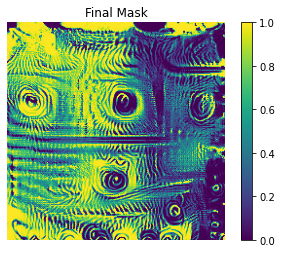

In [22]:
plt.imshow(final_mask.squeeze().cpu().numpy(), cmap='viridis')
plt.title("Final Mask")
plt.colorbar()
plt.axis('off')
plt.show()